# SimpleDemo

The purpose of this notebook is to give a quick demonstration of how to use the MiniScatter Python interface, including running single simulations, getting the data, caching, and scans.

## Code setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import ROOT
import os

Welcome to JupyROOT 6.14/08


In [2]:
#Setup MiniScatter -- modify the path to where you built MiniScatter!
import sys
MiniScatter_path="../build/."
sys.path.append(MiniScatter_path)

import miniScatterDriver
import miniScatterScanner
import miniScatterPlots

/usr/lib64/python3.6/site-packages/ROOT.py:461: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _orig_ihook( name, *args, **kwds )


In [3]:
#Enable zooming etc. on MATPLOTLIB plots inside JuPyter

%matplotlib notebook

#If necessary, set different figsizes and get the color cycle
#
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
# 
# colorCycle = plt.rcParams['axes.prop_cycle']
# plt.rcParams['figure.max_open_warning'] = 100

In [4]:
#Disable putting scroll bars on the output if it is long
#
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#     return false;
# }

## Simulation setup

In [5]:
### Basic simulation parameters ###

QUIET   = False #Reduced output?
TRYLOAD = True  #Try to load already existing data instead of recomputing?
NUM_THREADS = 4 #Number of parallel threads to use for scans
#Where to store temporary data for scans (a fast file system, NOT EOS/AFS)
TMPFOLDER = "/tmp/miniScatter/SimpleDemo_thicknessScan"

#When making multiple scans, it's nice to first create a `baseSimSetup` and then modify it for each simulation
# Note: each argument here corresponds roughly to a command line argument.
# Look inside miniScatterDriver.runScatter() to see how.

baseSimSetup = {}
#baseSimSetup["PHYS"] = "QGSP_BERT__SS" #Use the __SS physics lists for thin foils
baseSimSetup["PHYS"]  = "QGSP_BERT"
baseSimSetup["N"]     = 10000 #Just a few events here! Remember that thicker targets are slower

baseSimSetup["ENERGY"] = 215.0 #[MeV]

#Use a distribution defined by Twiss parameters instead of a pencil beam?
#EPS   = 3.0 #[um]
#BETA  = 1.4 #[m]
#ALPHA = 0.0
#baseSimSetup["COVAR"] = (EPS,BETA,ALPHA)

#Use a flat distribution or cut the tails of the Gaussian?
#baseSimSetup["BEAM_RCUT"] = 3.0

#Where to start the beam.
#baseSimSetup["ZOFFSET_BACKTRACK"] = True
baseSimSetup["ZOFFSET"]           = 0.0 #Auto

#Beam particle type
baseSimSetup["BEAM"]    = "e-"

baseSimSetup["WORLDSIZE"] = 1000.0 #Make the world wider

#Target is 10 mm of aluminium
baseSimSetup["THICK"] = 10
baseSimSetup["MAT"] = "G4_Al"

#Detector distance from target center [mm] 
baseSimSetup["DIST"] = 3000.0 

#Some d
baseSimSetup["QUICKMODE"] = False #Include slow plots
baseSimSetup["MINIROOT"]  = True #Skip TTRees in the .root files
baseSimSetup["EDEP_DZ"]   = 1.0

#Store the .root files in a subfolder from where this script is running,
# normally MiniScatter/examples, in order to keep things together
baseSimSetup["OUTFOLDER"] = os.path.join(os.getcwd(),"SimpleDemo")


## Just a simple simulation

Here we run a short simulation and load the data. No caching

In [6]:
#Run the simulation

simSetup_simple1 = baseSimSetup.copy()
#Give the .root file a name
simSetup_simple1["OUTNAME"] = "simple1"

miniScatterDriver.runScatter(simSetup_simple1, quiet=QUIET)

Running command line: './MiniScatter -t 10 -m G4_Al -d 3000.0 -w 1000.0 -p QGSP_BERT -n 10000 -e 215.0 -b e- -z 0.0 -f simple1 -o /home/kyrsjo/cernbox/MiniScatter/examples/SimpleDemo -r --edepDZ 1.0'
RunFolder = '/home/kyrsjo/cernbox/MiniScatter/build'
Done!


In [7]:
#Load the data
(twiss_simple1, numPart_simple1, objects_simple1) = \
    miniScatterDriver.getData(filename=os.path.join(simSetup_simple1["OUTFOLDER"],simSetup_simple1["OUTNAME"])+".root",\
                              quiet=QUIET, getObjects=["targetEdep","target_edep_dens","target_edep_rdens","metadata"])

#Look at the catch
print ("TWISS:")
print (twiss_simple1.keys())
print (" |- ", twiss_simple1['init'].keys())
print (" |    |- ", twiss_simple1['init']['x'].keys())
print (" |    |- ", twiss_simple1['init']['x'].keys())
print()
print("twiss_simple1['target_exit']['x']['alpha'] =", twiss_simple1['target_exit']['x']['alpha'])
print()
print()

print("NUMPART:")
print(numPart_simple1.keys())
print("numPart_simple1['target'] =", numPart_simple1['target'])
print()
print()

print("OBJECTS:")
print(objects_simple1.keys())
print("objects_simple1['targetEdep'] =", objects_simple1['targetEdep'])

TWISS:
dict_keys(['init', 'target_exit', 'target_exit_cutoff', 'tracker', 'tracker_cutoff'])
 |-  dict_keys(['x', 'y'])
 |    |-  dict_keys(['eps', 'beta', 'alpha', 'posAve', 'angAve'])
 |    |-  dict_keys(['eps', 'beta', 'alpha', 'posAve', 'angAve'])

twiss_simple1['target_exit']['x']['alpha'] = -0.003770939806239008


NUMPART:
dict_keys(['tracker', 'tracker_cutoff', 'target', 'target_cutoff'])
numPart_simple1['target'] = {-11: 72.0, 11: 11087.0, 22: 12785.0}


OBJECTS:
dict_keys(['targetEdep', 'target_edep_dens', 'target_edep_rdens', 'metadata'])
objects_simple1['targetEdep'] = <ROOT.TH1D object ("targetEdep-localClone") at 0x55981b85a6f0>


Note: Here, only 3 of the many possible objects were loaded from the .root file.
To see all of them, enter the folder `MiniScatter/examples/SimpleDemo` and run `rootls simple1.root`.

Typical output:
```
$ rootls -t simple1.root 
TGraph            Feb 22 10:29 2019 Graph                                 "Graph"
TH2D              Feb 22 10:29 2019 init_x                                "Initial phase space (x)"
TVectorT<double>  Feb 22 10:29 2019 init_x_TWISS                          ""
TH2D              Feb 22 10:29 2019 init_xy                               "Initial phase space (x,y)"
TH2D              Feb 22 10:29 2019 init_y                                "Initial phase space (y)"
TVectorT<double>  Feb 22 10:29 2019 init_y_TWISS                          ""
TVectorT<double>  Feb 22 10:29 2019 metadata                              ""
TCanvas           Feb 22 10:29 2019 scatterPlot                           ""
TVectorT<double>  Feb 22 10:29 2019 target_cutoff_ParticleTypes_numpart   ""
TVectorT<double>  Feb 22 10:29 2019 target_cutoff_ParticleTypes_PDG       ""
TH3D              Feb 22 10:29 2019 target_edep_dens                      "Target energy deposition density [MeV/bin]"
TH2D              Feb 22 10:29 2019 target_edep_rdens                     "Target radial energy deposition density [MeV/bin]"
TH1D              Feb 22 10:29 2019 target_exit_angle                     "Exit angle from target"
TH1D              Feb 22 10:29 2019 target_exit_angle_cutoff              "Exit angle from target (charged, energy > Ecut, r < Rcut)"
TH1D              Feb 22 10:29 2019 target_exit_cutoff_energy_PDG-11      "Particle energy when exiting target (positrons) (r < Rcut)"
TH1D              Feb 22 10:29 2019 target_exit_cutoff_energy_PDG11       "Particle energy when exiting target (electrons) (r < Rcut)"
TH1D              Feb 22 10:29 2019 target_exit_cutoff_energy_PDG22       "Particle energy when exiting target (photons) (r < Rcut)"
TH1D              Feb 22 10:29 2019 target_exit_cutoff_energy_PDGother    "Particle energy when exiting target (other) (r < Rcut)"
TH2D              Feb 22 10:29 2019 target_exit_cutoff_x                  "Target exit phase space (x) (charged, energy > Ecut, r < Rcut)"
TVectorT<double>  Feb 22 10:29 2019 target_exit_cutoff_x_TWISS            ""
TH2D              Feb 22 10:29 2019 target_exit_cutoff_y                  "Target exit phase space (y) (charged, energy > Ecut, r < Rcut)"
TVectorT<double>  Feb 22 10:29 2019 target_exit_cutoff_y_TWISS            ""
TH1D              Feb 22 10:29 2019 target_exit_energy_PDG-11             "Particle energy when exiting target (positrons)"
TH1D              Feb 22 10:29 2019 target_exit_energy_PDG11              "Particle energy when exiting target (electrons)"
TH1D              Feb 22 10:29 2019 target_exit_energy_PDG22              "Particle energy when exiting target (photons)"
TH1D              Feb 22 10:29 2019 target_exit_energy_PDGother           "Particle energy when exiting target (other)"
TH1D              Feb 22 10:29 2019 target_exit_rpos_cutoff_PDG-11        "target exit rpos (positrons, energy > E_cut)"
TH1D              Feb 22 10:29 2019 target_exit_rpos_cutoff_PDG11         "target exit rpos (electrons, energy > E_cut)"
TH1D              Feb 22 10:29 2019 target_exit_rpos_cutoff_PDG22         "target exit rpos (photons, energy > E_cut)"
TH1D              Feb 22 10:29 2019 target_exit_rpos_cutoff_PDGother      "target exit rpos (other, energy > E_cut)"
TH1D              Feb 22 10:29 2019 target_exit_rpos_PDG-11               "target exit rpos (positrons)"
TH1D              Feb 22 10:29 2019 target_exit_rpos_PDG11                "target exit rpos (electrons)"
TH1D              Feb 22 10:29 2019 target_exit_rpos_PDG22                "target exit rpos (photons)"
TH1D              Feb 22 10:29 2019 target_exit_rpos_PDGother             "target exit rpos (other)"
TH2D              Feb 22 10:29 2019 target_exit_x                         "Target exit phase space (x)"
TVectorT<double>  Feb 22 10:29 2019 target_exit_x_TWISS                   ""
TH2D              Feb 22 10:29 2019 target_exit_y                         "Target exit phase space (y)"
TVectorT<double>  Feb 22 10:29 2019 target_exit_y_TWISS                   ""
TVectorT<double>  Feb 22 10:29 2019 target_ParticleTypes_numpart          ""
TVectorT<double>  Feb 22 10:29 2019 target_ParticleTypes_PDG              ""
TH1D              Feb 22 10:29 2019 targetEdep                            "targetEdep"
TH1D              Feb 22 10:29 2019 targetEdep_IEL                        "targetEdep_IEL"
TH1D              Feb 22 10:29 2019 targetEdep_NIEL                       "targetEdep_NIEL"
TTree             Feb 22 10:29 2019 TargetExit                            "TargetExit tree"
  TargetExitBranch  "x/D:y:z:px:py:pz:E:PDG/I:charge:eventID"  0
TH1D              Feb 22 10:29 2019 tracker_cutoff_energy_PDG-11          "Particle energy when hitting tracker (positrons) (r < Rcut)"
TH1D              Feb 22 10:29 2019 tracker_cutoff_energy_PDG11           "Particle energy when hitting tracker (electrons) (r < Rcut)"
TH1D              Feb 22 10:29 2019 tracker_cutoff_energy_PDG22           "Particle energy when hitting tracker (photons) (r < Rcut)"
TH1D              Feb 22 10:29 2019 tracker_cutoff_energy_PDGother        "Particle energy when hitting tracker (other) (r < Rcut)"
TVectorT<double>  Feb 22 10:29 2019 tracker_cutoff_ParticleTypes_numpart  ""
TVectorT<double>  Feb 22 10:29 2019 tracker_cutoff_ParticleTypes_PDG      ""
TH2D              Feb 22 10:29 2019 tracker_cutoff_x                      "Tracker phase space (x) (charged, energy > Ecut, r < Rcut)"
TVectorT<double>  Feb 22 10:29 2019 tracker_cutoff_x_TWISS                ""
TH2D              Feb 22 10:29 2019 tracker_cutoff_y                      "Tracker phase space (y) (charged, energy > Ecut, r < Rcut)"
TVectorT<double>  Feb 22 10:29 2019 tracker_cutoff_y_TWISS                ""
TH1D              Feb 22 10:29 2019 tracker_energy_PDG-11                 "Particle energy when hitting tracker (positrons)"
TH1D              Feb 22 10:29 2019 tracker_energy_PDG11                  "Particle energy when hitting tracker (electrons)"
TH1D              Feb 22 10:29 2019 tracker_energy_PDG22                  "Particle energy when hitting tracker (photons)"
TH1D              Feb 22 10:29 2019 tracker_energy_PDGother               "Particle energy when hitting tracker (other)"
TVectorT<double>  Feb 22 10:29 2019 tracker_ParticleTypes_numpart         ""
TVectorT<double>  Feb 22 10:29 2019 tracker_ParticleTypes_PDG             ""
TH1D              Feb 22 10:29 2019 tracker_rpos_cutoff_PDG-11            "tracker rpos (positrons, energy > E_cut)"
TH1D              Feb 22 10:29 2019 tracker_rpos_cutoff_PDG11             "tracker rpos (electrons, energy > E_cut)"
TH1D              Feb 22 10:29 2019 tracker_rpos_cutoff_PDG22             "tracker rpos (photons, energy > E_cut)"
TH1D              Feb 22 10:29 2019 tracker_rpos_cutoff_PDGother          "tracker rpos (other, energy > E_cut)"
TH1D              Feb 22 10:29 2019 tracker_rpos_PDG-11                   "tracker rpos (positrons)"
TH1D              Feb 22 10:29 2019 tracker_rpos_PDG11                    "tracker rpos (electrons)"
TH1D              Feb 22 10:29 2019 tracker_rpos_PDG22                    "tracker rpos (photons)"
TH1D              Feb 22 10:29 2019 tracker_rpos_PDGother                 "tracker rpos (other)"
TH2D              Feb 22 10:29 2019 tracker_x                             "Tracker phase space (x)"
TVectorT<double>  Feb 22 10:29 2019 tracker_x_TWISS                       ""
TH2D              Feb 22 10:29 2019 tracker_y                             "Tracker phase space (y)"
TVectorT<double>  Feb 22 10:29 2019 tracker_y_TWISS                       ""
TTree             Feb 22 10:29 2019 TrackerHits                           "TrackerHits tree"
  TrackerHitsBranch  "x/D:y:z:px:py:pz:E:PDG/I:charge:eventID"  0

```

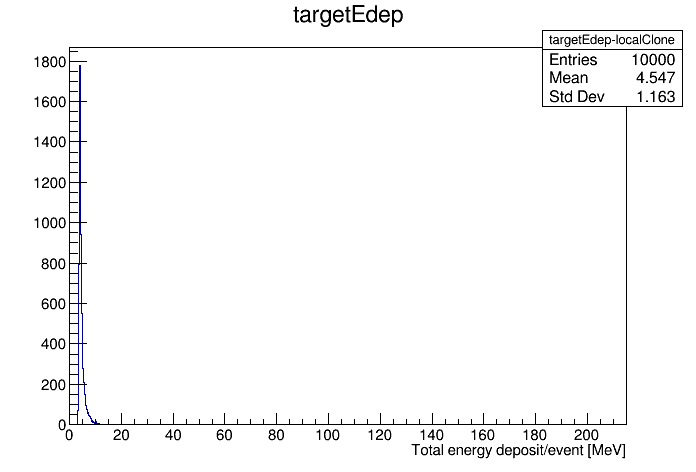

In [8]:
canvas = ROOT.TCanvas()
objects_simple1['targetEdep'].Draw()
canvas.Draw()

In [9]:
# Run & load in one step, with results caching
(twiss_simple1, numPart_simple1, objects_simple1) = \
    miniScatterDriver.getData_tryLoad(simSetup_simple1, tryload=TRYLOAD,\
    getObjects=["targetEdep","target_edep_dens","target_edep_rdens","metadata"])

Found a file at '/home/kyrsjo/cernbox/MiniScatter/examples/SimpleDemo/simple1.root', loading!


## A parameter scan

As an example, let's look at the number of positrons coming out of a Tungsten target as a function of thickness, and their energy distributions.

In [10]:
baseSimSetup_W = baseSimSetup.copy()
baseSimSetup_W["MAT"] = "G4_W"
baseSimSetup_W["N"]   = baseSimSetup_W["N"]*10 #Make more events for nicer plots, but this takes TIME
del baseSimSetup_W["THICK"] #Can't have the key we're scanning in the baseSimSetup
del baseSimSetup_W["OUTFOLDER"] #Can't have OUTFOLDER in baseSimSetup

thickScan_W = np.linspace(0.5,100,10)
print ("thickScan_W =",thickScan_W, "[mm]")
print()

(twiss_W, numPart_W, objects_W, analysis_output_W) = \
    miniScatterScanner.ScanMiniScatter("THICK",thickScan_W,baseSimSetup_W, \
                                       NUM_THREADS=NUM_THREADS,tryLoad=TRYLOAD,\
                                       COMMENT="SimpleDemo-TargetThickness-W", QUIET=QUIET,\
                                       tmpFolder=TMPFOLDER, getObjects=['target_exit_energy_PDG-11', 'targetEdep'])


thickScan_W = [  0.5         11.55555556  22.61111111  33.66666667  44.72222222
  55.77777778  66.83333333  77.88888889  88.94444444 100.        ] [mm]

LoadFile filename and status: 'SaveSim_THICK_SimpleDemo-TargetThickness-W.h5' True
Loading...
Scan variable ranges match, let's load!
Auxillary ROOT file SaveSim_THICK_SimpleDemo-TargetThickness-W.root loaded.
Loaded! That was fast.


[ 1526. 51778. 18230.  6160.  2142.   890.   485.   366.   296.   309.]


<IPython.core.display.Javascript object>


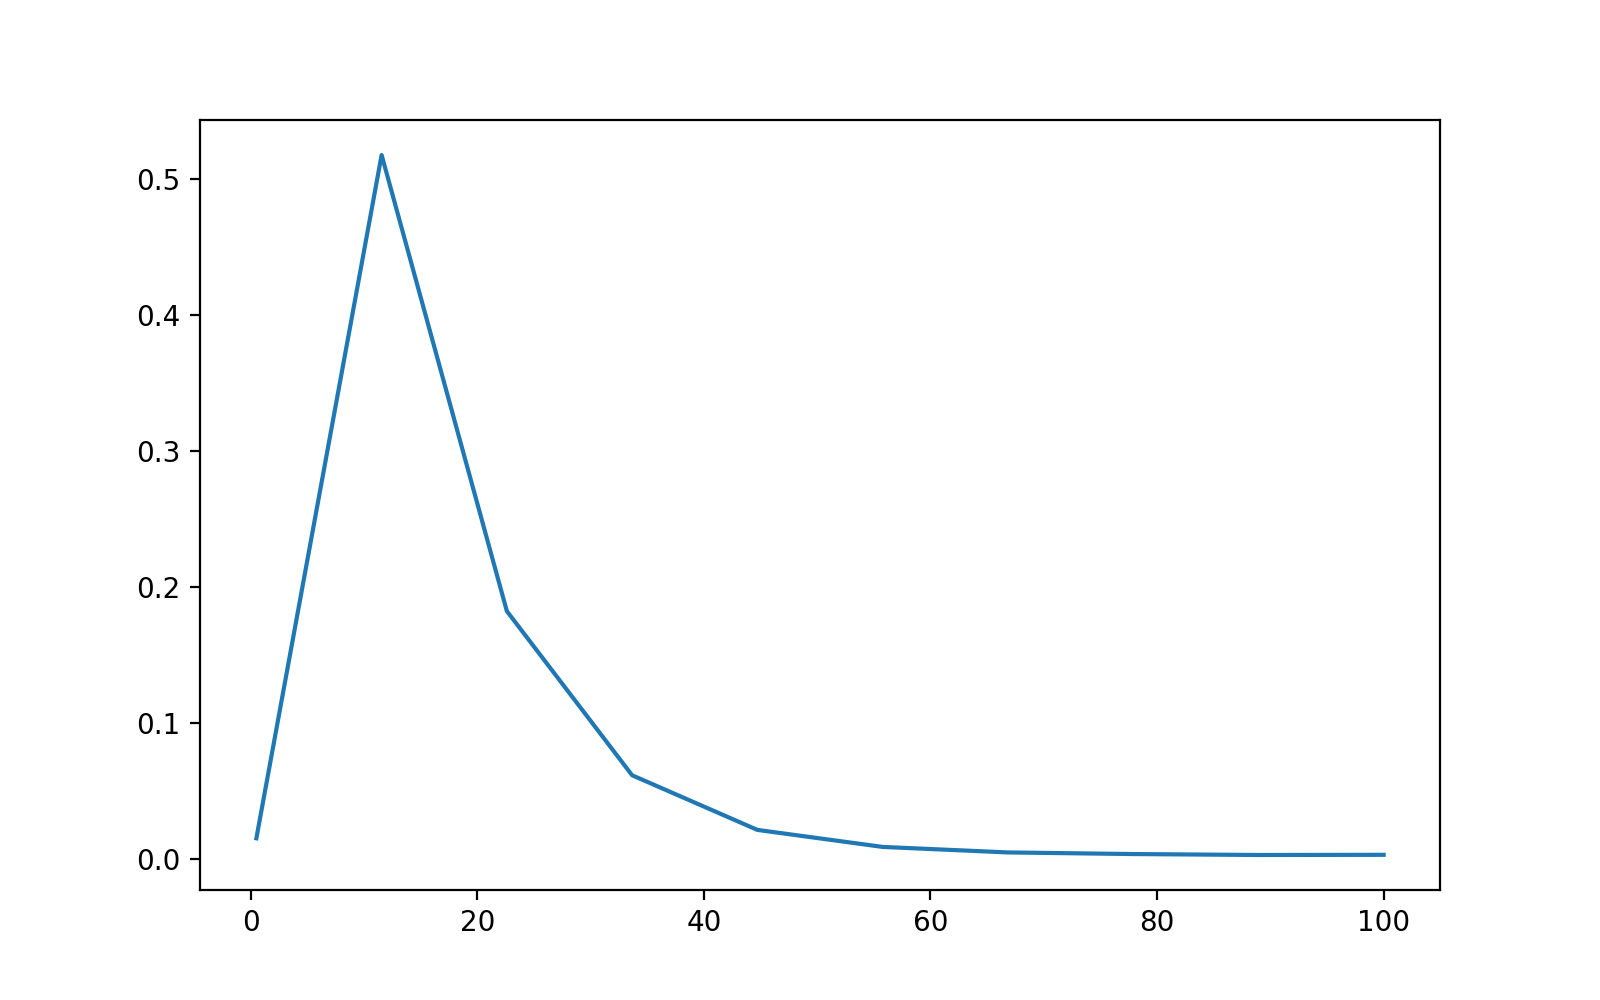

In [11]:
#Let's look at the catch!
print(numPart_W['target'][-11])

plt.figure()
plt.plot(thickScan_W,numPart_W['target'][-11]/baseSimSetup_W['N'])
plt.show()

In [12]:
#Histograms
print(objects_W.keys())
print(objects_W['target_exit_energy_PDG-11'])
print()

dict_keys(['target_exit_energy_PDG-11', 'targetEdep'])
[<ROOT.TH1D object ("target_exit_energy_PDG-11_THICK_0_SimpleDemo-TargetThickness-W") at 0x55981e69a2c0>, <ROOT.TH1D object ("target_exit_energy_PDG-11_THICK_1_SimpleDemo-TargetThickness-W") at 0x55981a255a10>, <ROOT.TH1D object ("target_exit_energy_PDG-11_THICK_2_SimpleDemo-TargetThickness-W") at 0x55981a206690>, <ROOT.TH1D object ("target_exit_energy_PDG-11_THICK_3_SimpleDemo-TargetThickness-W") at 0x55981e57bcb0>, <ROOT.TH1D object ("target_exit_energy_PDG-11_THICK_4_SimpleDemo-TargetThickness-W") at 0x55981e57c370>, <ROOT.TH1D object ("target_exit_energy_PDG-11_THICK_5_SimpleDemo-TargetThickness-W") at 0x55981e57d7c0>, <ROOT.TH1D object ("target_exit_energy_PDG-11_THICK_6_SimpleDemo-TargetThickness-W") at 0x55981e403290>, <ROOT.TH1D object ("target_exit_energy_PDG-11_THICK_7_SimpleDemo-TargetThickness-W") at 0x55981e403da0>, <ROOT.TH1D object ("target_exit_energy_PDG-11_THICK_8_SimpleDemo-TargetThickness-W") at 0x55981e408810>,

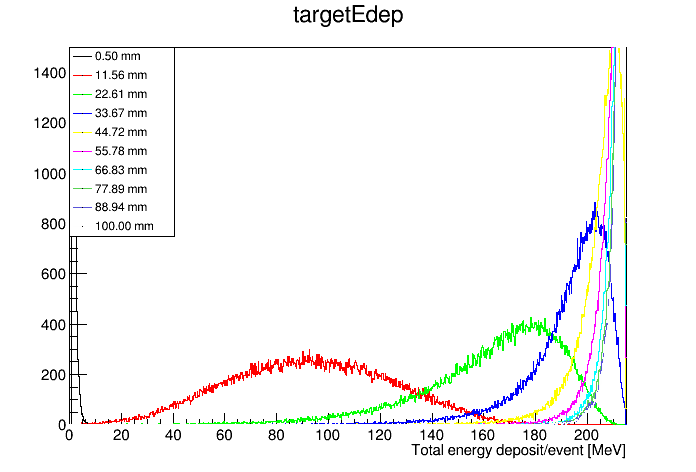

In [13]:
canvas = ROOT.TCanvas()
hasDrawn = False
edepLegend = None
for iThick in range(len(thickScan_W)):
    objects_W['targetEdep'][iThick].SetLineColor(iThick+1)
    objects_W['targetEdep'][iThick].GetYaxis().SetRangeUser(0,1500)  
    objects_W['targetEdep'][iThick].SetStats(False)
    if hasDrawn:
        option='same'
    else:
        option = ''
        edepLegend = ROOT.TLegend(0.1,0.9, 0.25, 0.5)
        
    objects_W['targetEdep'][iThick].Draw(option)
    hasDrawn = True
    
    edepLegend.AddEntry(objects_W['targetEdep'][iThick], "{:.2f} mm".format(thickScan_W[iThick]))
edepLegend.Draw()
canvas.Draw()

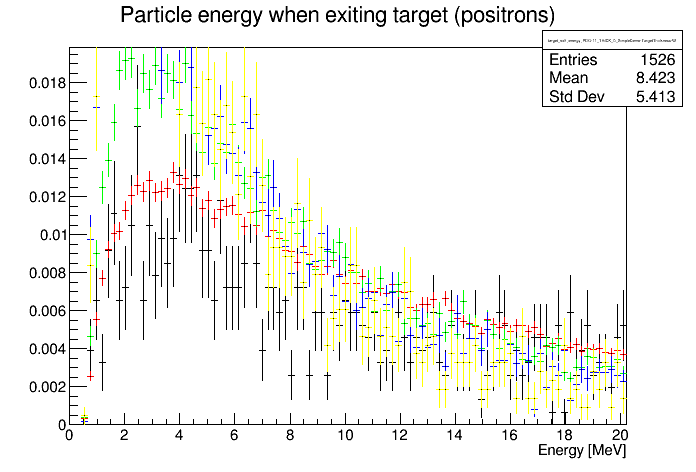

In [14]:
canvas = ROOT.TCanvas()
hasDrawn = False
for iThick in range(len(thickScan_W)):
    count = objects_W['target_exit_energy_PDG-11'][iThick].Integral()
    if count < 1000:
        continue
    objects_W['target_exit_energy_PDG-11'][iThick].SetLineColor(iThick+1)
    objects_W['target_exit_energy_PDG-11'][iThick].GetXaxis().SetRangeUser(0,20)
    objects_W['target_exit_energy_PDG-11'][iThick].Scale(1/count)
    
    if hasDrawn:
        option='same'
    else:
        option = ''
        
    objects_W['target_exit_energy_PDG-11'][iThick].Draw(option)
    hasDrawn = True
canvas.Draw()